In [12]:
!python -V

Python 3.9.16


In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [22]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000") # use this better instead of the sqllite link
mlflow.set_experiment("taxi-problem-dev")

2023/05/03 15:23:48 INFO mlflow.tracking.fluent: Experiment with name 'taxi-problem-dev' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/5', creation_time=1683145428747, experiment_id='5', last_update_time=1683145428747, lifecycle_stage='active', name='taxi-problem-dev', tags={}>

In [23]:
df = pd.read_parquet('./data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [24]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667


In [25]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.0603515418008636

/var/folders/s4/06dmdnk558g26lnd0hlpzlbw0000gp/T/ipykernel_38308/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/s4/06dmdnk558g26lnd0hlpzlbw0000gp/T/ipykernel_38308/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

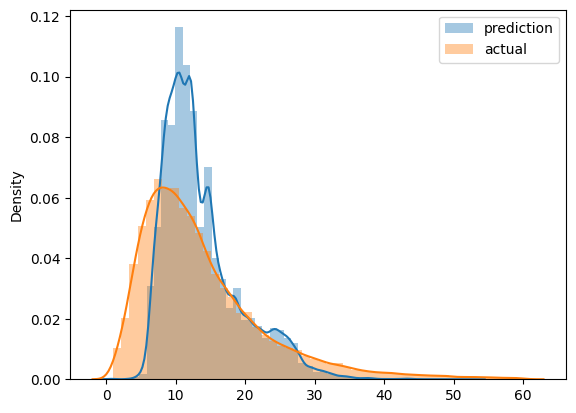

In [26]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [27]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [28]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [29]:
len(df_train), len(df_val)

(65946, 62574)

In [30]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [31]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [32]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [40]:
with mlflow.start_run(run_name="testing-mlflow"):
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="sklearn-model",
        registered_model_name="sk-learn-linear-reg-model",
    )

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("RSME", rmse)

Registered model 'sk-learn-linear-reg-model' already exists. Creating a new version of this model...
2023/05/03 15:33:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-linear-reg-model, version 3
Created version '3' of model 'sk-learn-linear-reg-model'.


In [34]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [36]:
with mlflow.start_run():
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mean_squared_error(y_val, y_pred, squared=False)